# Model fitting for MetMCC-SCAN
## Yanrong (Jerry) Ji

## TODO:
- build a pipeline for preprocessing
>- further group some levels and compare
>- missing val: imputation/leave as it is
>- more feature engineering?
- bayesian optimization (done)
- merge SEER data
- bagged XGBoost

## Major issues:
- Categorical + Numeric
- Missing values
- Imbalance

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost
# !pip install scikit-optimize
# !pip install imblearn

In [38]:
# general modules
import os
from copy import deepcopy
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import accuracy_score,confusion_matrix, auc, roc_auc_score
from sklearn.metrics import roc_curve, f1_score, average_precision_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, make_scorer
from sklearn.impute import KNNImputer

# xgboost,lightgbm,catboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Bayesian optimization
from skopt import BayesSearchCV
from skopt import callbacks
from skopt.space import Real, Integer

# Class imbalance
from imblearn.over_sampling import SMOTENC
from imblearn.ensemble import BalancedRandomForestClassifier

# set seaborn style
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
sns.set(font_scale=1.5)

In [3]:
BASE_DIR = os.path.dirname(os.path.realpath('model_fitting')) + '/'

In [4]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_clean.pkl')

In [5]:
mcc_ncdb.head()

,DEPTH,TUMOR_SIZE,PRIMARY_SITE,AGE,SEX,GROWTH_PATTERN,HISTOLOGY,LATERALITY,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,TUMOR_BASE_TRANSECTION,SLNB,YEAR_SINCE_DIAGNOSIS
8,999.0,1,C444,71,1,999,8247,0,0,999,999,999,0.0,5
14,1.0,2,C443,43,1,999,8247,2,9,0,0,20,0.0,2
19,50.0,25,C447,59,2,999,8247,1,0,999,999,999,0.0,2
23,999.0,14,C443,82,2,1,8247,2,0,999,0,20,0.0,3
31,62.0,15,C447,90,1,999,8247,1,0,999,999,20,0.0,2


## Split data

In [5]:
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE','LYMPH_VASCULAR_INVASION',
                        'TUMOR_SIZE', 'DEPTH', 'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 'SLNB'
                       ]]
mcc_ncdb_sel = pd.get_dummies(mcc_ncdb_sel)
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [6]:
# all features
mcc_ncdb = pd.get_dummies(mcc_ncdb)
X = np.array(mcc_ncdb.loc[:, mcc_ncdb.columns != 'SLNB'])
y = np.array(mcc_ncdb.loc[:, mcc_ncdb.columns == 'SLNB'])
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.1, 
                                                    random_state = 123) # set seed to ensure reproducibility

In [7]:
X_train.shape

(6048, 75)

In [8]:
X_train_sel.shape

(6048, 32)

In [9]:
mcc_ncdb.columns

Index(['DEPTH', 'TUMOR_SIZE', 'AGE', 'SEX', 'SLNB', 'YEAR_SINCE_DIAGNOSIS',
       'PRIMARY_SITE_C440', 'PRIMARY_SITE_C441', 'PRIMARY_SITE_C442',
       'PRIMARY_SITE_C443', 'PRIMARY_SITE_C444', 'PRIMARY_SITE_C445',
       'PRIMARY_SITE_C446', 'PRIMARY_SITE_C447', 'PRIMARY_SITE_C448',
       'PRIMARY_SITE_C449', 'GROWTH_PATTERN_1.0', 'GROWTH_PATTERN_20.0',
       'GROWTH_PATTERN_999.0', 'HISTOLOGY_8140', 'HISTOLOGY_8143',
       'HISTOLOGY_8147', 'HISTOLOGY_8200', 'HISTOLOGY_8240', 'HISTOLOGY_8246',
       'HISTOLOGY_8247', 'HISTOLOGY_8260', 'HISTOLOGY_8310', 'HISTOLOGY_8323',
       'HISTOLOGY_8347', 'HISTOLOGY_8390', 'HISTOLOGY_8400', 'HISTOLOGY_8401',
       'HISTOLOGY_8402', 'HISTOLOGY_8407', 'HISTOLOGY_8409', 'HISTOLOGY_8410',
       'HISTOLOGY_8413', 'HISTOLOGY_8430', 'HISTOLOGY_8480', 'HISTOLOGY_8481',
       'HISTOLOGY_8490', 'HISTOLOGY_8500', 'HISTOLOGY_8573', 'HISTOLOGY_8832',
       'HISTOLOGY_8833', 'HISTOLOGY_8891', 'HISTOLOGY_9120', 'LATERALITY_0',
       'LATERALITY_1', 

In [10]:
mcc_ncdb_sel.columns

Index(['AGE', 'SEX', 'TUMOR_SIZE', 'DEPTH', 'SLNB', 'PRIMARY_SITE_C440',
       'PRIMARY_SITE_C441', 'PRIMARY_SITE_C442', 'PRIMARY_SITE_C443',
       'PRIMARY_SITE_C444', 'PRIMARY_SITE_C445', 'PRIMARY_SITE_C446',
       'PRIMARY_SITE_C447', 'PRIMARY_SITE_C448', 'PRIMARY_SITE_C449',
       'LYMPH_VASCULAR_INVASION_0.0', 'LYMPH_VASCULAR_INVASION_1.0',
       'LYMPH_VASCULAR_INVASION_8.0', 'LYMPH_VASCULAR_INVASION_9.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_0.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_1.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_20.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_30.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_999.0', 'IMMUNE_SUPPRESSION_0.0',
       'IMMUNE_SUPPRESSION_1.0', 'IMMUNE_SUPPRESSION_20.0',
       'IMMUNE_SUPPRESSION_30.0', 'IMMUNE_SUPPRESSION_40.0',
       'IMMUNE_SUPPRESSION_50.0', 'IMMUNE_SUPPRESSION_60.0',
       'IMMUNE_SUPPRESSION_70.0', 'IMMUNE_SUPPRESSION_999.0'],
      dtype='object')

## Balance dataset by SMOTE

In [11]:
cat_features_idx = list(range(4,74,1))
cat_features_idx.append(3)
sm = SMOTENC(random_state=123, categorical_features = cat_features_idx) # set seed to ensure reproducibility
X_train_balanced, y_train_balanced = sm.fit_sample(X_train, y_train.ravel())

cat_features_idx_sel = list(range(5,31,1))
cat_features_idx_sel.append(1)
sm_sel = SMOTENC(random_state=123, categorical_features = cat_features_idx_sel) 
X_train_sel_balanced, y_train_sel_balanced = sm_sel.fit_sample(X_train_sel, y_train_sel.ravel())

In [12]:
X_train_balanced.shape

(10494, 75)

In [13]:
X_train_sel_balanced.shape

(10494, 32)

In [18]:
def negative_pred_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    return TN/(TN+FN)

## Baseline: logistic regression (selected vars, not binned)

In [32]:
log_clf_sel = LogisticRegression(penalty='none', max_iter=10000)
log_clf_sel.fit(X_train_sel_balanced,y_train_sel_balanced.ravel())
y_prob_sel = np.asarray(log_clf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(log_clf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print(confusion_matrix(y_test_sel, y_pred_sel))
print("test accuracy: %s" % log_clf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

[[527  74]
 [ 51  21]]
test accuracy: 0.8142644873699851
test NPV: 0.9117647058823529
test Precision: 0.22105263157894736
test Recall: 0.2916666666666667
test AUC: 0.7141107413569976
test F1: 0.251497005988024
test AUPR: 0.20422642744811098


## logistic regression (all vars, not binned)

In [33]:
log_clf = LogisticRegression(penalty='none', max_iter=10000)
log_clf.fit(X_train_balanced,y_train_balanced.ravel())
y_prob = np.asarray(log_clf.predict_proba(X_test))
y_pred = np.asarray(log_clf.predict(X_test))
y_test = np.asarray(y_test)
print(confusion_matrix(y_test, y_pred))
print("test accuracy: %s" % log_clf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

[[466 135]
 [ 33  39]]
test accuracy: 0.75037147102526
test NPV: 0.9338677354709419
test Precision: 0.22413793103448276
test Recall: 0.5416666666666666
test AUC: 0.6898225180255131
test F1: 0.3170731707317073
test AUPR: 0.20015532598976626


## Random forest (selected vars, not binned)

In [34]:
# train a random forest classifier
rf_sel = RandomForestClassifier(oob_score=True, 
                                 random_state=123) # set seed to ensure reproducibility
rf_sel.fit(X_train_sel_balanced,y_train_sel_balanced.ravel())
y_prob_sel = np.asarray(rf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % rf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.8231797919762258
test NPV: 0.8950819672131147
test Precision: 0.12698412698412698
test Recall: 0.1111111111111111
test AUC: 0.6111804400073951
test F1: 0.11851851851851852
test AUPR: 0.13667237539548904


## Random forest (all vars, not binned)

In [35]:
# train a random forest classifier
rf = RandomForestClassifier(oob_score=True, 
                                 random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_balanced,y_train_balanced.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.8306092124814265
test NPV: 0.9051580698835274
test Precision: 0.20833333333333334
test Recall: 0.20833333333333334
test AUC: 0.6627842484747642
test F1: 0.20833333333333334
test AUPR: 0.17954013958163836


## Random forest (cost-sensitive, all vars, not binned)

In [37]:
# train a random forest classifier
rf = RandomForestClassifier(oob_score=True, 
                            class_weight={0:1,1:1.121e13},
                            random_state=42) # set seed to ensure reproducibility
rf.fit(X_train,y_train.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.7890044576523031
test NPV: 0.9135135135135135
test Precision: 0.2033898305084746
test Recall: 0.3333333333333333
test AUC: 0.660877703826955
test F1: 0.2526315789473684
test AUPR: 0.1649256411839471


## Balanced Random Forest

In [43]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1000,
                            max_depth=50,
                            max_features = 7,
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train,y_train.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.6419019316493314
test NPV: 0.9368932038834952
test Precision: 0.17624521072796934
test Recall: 0.6388888888888888
test AUC: 0.6944791088925865
test F1: 0.27627627627627627
test AUPR: 0.2063799588235088


## Bayesian optimization: RF (all vars, not binned)

In [46]:
# RandomForest + Bayesian optimization
opt_rf = BayesSearchCV(BalancedRandomForestClassifier(oob_score=True,
                                     random_state=123),
                       {
                        'n_estimators': (100,2000),
                        'max_depth': (5, 100),  
                        'criterion': ['gini','entropy'],
                        'max_features': (1, 75),
                       }, 
                        n_iter = 20, verbose = 5, n_jobs=6)

# callback handler
def on_step(optim_result):
    score = opt_rf.best_score_
    print("best score: %s" % score)
#     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
#         pkl.dump(opt_rf, pickle_file)
    if score >= 0.95:
        print('Interrupting...')
        return True
    
opt_rf.fit(X_train, y_train.ravel(), callback=[on_step])

print("best parameter set: %s" % opt_rf.best_params_)
print("val. score: %s" % opt_rf.best_score_)
# print("test score: %s" % opt_rf.score(X_test, y_test))
y_prob = np.asarray(opt_rf.predict_proba(X_test))
y_pred = np.asarray(opt_rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % opt_rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.615244708994709
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   15.2s remaining:   22.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   15.3s finished


best score: 0.6228505291005291
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    9.2s remaining:   13.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    9.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.6228505291005291
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.5s finished


best score: 0.6228505291005291
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    7.2s remaining:   10.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    7.2s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.6228505291005291
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.0s remaining:    7.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    3.9s remaining:    5.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    4.0s finished


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    7.5s remaining:   11.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   13.9s remaining:   20.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   14.0s finished


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.1s finished


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   11.0s remaining:   16.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   11.2s finished


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   12.0s remaining:   18.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.2s finished


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.9s finished


best score: 0.6335978835978836
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   23.0s remaining:   34.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   23.2s finished


best score: 0.6335978835978836
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.8s finished


best score: 0.6335978835978836
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    4.2s finished


best score: 0.6651785714285714
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   10.9s remaining:   16.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   11.0s finished


best score: 0.6651785714285714
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.6s finished


best score: 0.6651785714285714
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   15.7s remaining:   23.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   15.9s finished


best score: 0.6651785714285714
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    3.5s finished


best score: 0.6651785714285714
best parameter set: OrderedDict([('criterion', 'entropy'), ('max_depth', 5), ('max_features', 12), ('n_estimators', 677)])
val. score: 0.6651785714285714
test accuracy: 0.6760772659732541
test NPV: 0.9382151029748284
test Precision: 0.1906779661016949
test Recall: 0.625
test AUC: 0.7023941578850065
test F1: 0.2922077922077922
test AUPR: 0.20623990892095453


In [49]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=677,
                            max_depth=5,
                            max_features = 12,
                            criterion = 'entropy',
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train,y_train.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.6760772659732541
test NPV: 0.9382151029748284
test Precision: 0.1906779661016949
test Recall: 0.625
test AUC: 0.7023941578850065
test F1: 0.2922077922077922
test AUPR: 0.20623990892095453


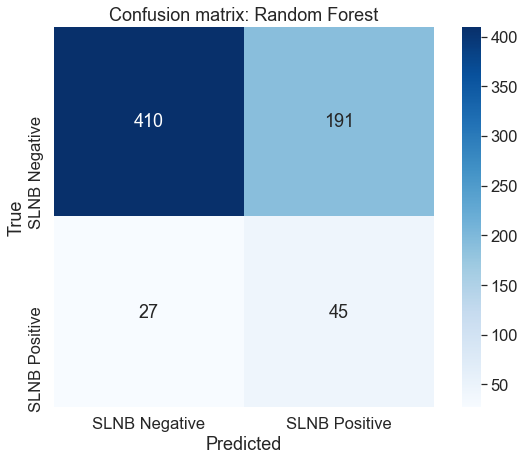

In [47]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [51]:
with open(BASE_DIR+'../model/balanced_rf.pkl', 'wb') as f:
    pkl.dump(rf, f)

## Binning the columns

In [6]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_clean.pkl')
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE',
                        'TUMOR_SIZE', 'DEPTH', 
                        'LYMPH_VASCULAR_INVASION', 
                        'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 
                        'GROWTH_PATTERN',
                        'TUMOR_BASE_TRANSECTION',
                        'SLNB'
                       ]]


In [7]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,1,C444,1,999.0,0,999,999,999,999,0.0
14,43,1,C443,2,1.0,9,0,0,999,20,0.0
19,59,2,C447,25,50.0,0,999,999,999,999,0.0
23,82,2,C443,14,999.0,0,999,0,1,20,0.0
31,90,1,C447,15,62.0,0,999,999,999,20,0.0


In [8]:
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].value_counts()

999.0    3670
1.0      1063
20.0      923
0.0       469
Name: TUMOR_BASE_TRANSECTION, dtype: int64

In [9]:
# binning the categories
mcc_ncdb_sel['SEX'] = mcc_ncdb_sel['SEX'].replace([1, 2],
                                                ['Male', 'Female']
                                               )
mcc_ncdb_sel['PRIMARY_SITE'] = mcc_ncdb_sel['PRIMARY_SITE'].replace(['C440','C441','C442','C443',
                                                                     'C444','C445','C446','C447',
                                                                     'C448','C449'],
                                                                    ['Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Other',
                                                                     'Head_and_Neck',
                                                                     'Trunk',
                                                                     'Extremity',
                                                                     'Extremity',
                                                                     'Other',
                                                                     'Other']
                                                                   )
mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].replace([0, 1, 8, 9],
                                                                                          ['No',
                                                                                           'Yes',
                                                                                           'Unknown',
                                                                                           'Unknown'
                                                                                          ])
mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].replace(
                                                                                          [0, 1, 20, 30, 999],
                                                                                          ['Negative',
                                                                                           'Weak',
                                                                                           'Strong',
                                                                                           'Present',
                                                                                           'Unknown'
                                                                                          ])
mcc_ncdb_sel['IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].replace(
                                                                              [0, 1, 20, 30, 40,
                                                                               50, 60, 70, 999],
                                                                              ['Negative',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Unknown'
                                                                              ])
mcc_ncdb_sel['GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].replace([1, 20, 999],
                                                                          ['Circumscribed_nodular',
                                                                           'Diffusely_infiltrative',
                                                                           'Unknown'])

mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].replace([0, 1, 20, 999],
                                                                                          ['Not_found',
                                                                                           'Transected',
                                                                                           'Not_transected',
                                                                                           'Unknown'
                                                                                          ])

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a cop

## Imputing DEPTH and TUMOR_SIZE to be zero

In [10]:
mcc_ncdb_sel['DEPTH'] = mcc_ncdb_sel['DEPTH'].replace([999],[0])
mcc_ncdb_sel['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE'].replace([999],[0])

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,Male,Head_and_Neck,1,0.0,No,Unknown,Unknown,Unknown,Unknown,0.0
14,43,Male,Other,2,1.0,Unknown,Negative,Negative,Unknown,Not_transected,0.0
19,59,Female,Extremity,25,50.0,No,Unknown,Unknown,Unknown,Unknown,0.0
23,82,Female,Other,14,0.0,No,Unknown,Negative,Circumscribed_nodular,Not_transected,0.0
31,90,Male,Extremity,15,62.0,No,Unknown,Unknown,Unknown,Not_transected,0.0


In [12]:
mcc_ncdb_sel.TUMOR_SIZE.value_counts()

0      1203
1       421
992     321
15      303
20      259
       ... 
320       1
280       1
160       1
148       1
153       1
Name: TUMOR_SIZE, Length: 111, dtype: int64

In [13]:
# save cleaned data
mcc_ncdb_sel.to_csv(BASE_DIR+"../data/Merkel_NCDB_clean_selectedVars.csv")
mcc_ncdb_sel.to_pickle(BASE_DIR+"../data/Merkel_NCDB_clean_selectedVars.pkl")

In [14]:
mcc_ncdb_sel = pd.get_dummies(mcc_ncdb_sel)
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [15]:
X_train_sel.shape

(5512, 27)

In [16]:
mcc_ncdb_sel.columns

Index(['AGE', 'TUMOR_SIZE', 'DEPTH', 'SLNB', 'SEX_Female', 'SEX_Male',
       'PRIMARY_SITE_Extremity', 'PRIMARY_SITE_Head_and_Neck',
       'PRIMARY_SITE_Other', 'PRIMARY_SITE_Trunk',
       'LYMPH_VASCULAR_INVASION_No', 'LYMPH_VASCULAR_INVASION_Unknown',
       'LYMPH_VASCULAR_INVASION_Yes',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Negative',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Present',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Strong',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Unknown',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Weak', 'IMMUNE_SUPPRESSION_Negative',
       'IMMUNE_SUPPRESSION_Positive', 'IMMUNE_SUPPRESSION_Unknown',
       'GROWTH_PATTERN_Circumscribed_nodular',
       'GROWTH_PATTERN_Diffusely_infiltrative', 'GROWTH_PATTERN_Unknown',
       'TUMOR_BASE_TRANSECTION_Not_found',
       'TUMOR_BASE_TRANSECTION_Not_transected',
       'TUMOR_BASE_TRANSECTION_Transected', 'TUMOR_BASE_TRANSECTION_Unknown'],
      dtype='object')

In [19]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1000,
                            max_depth=50,
                            max_features = 7,
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.5970636215334421
test NPV: 0.8872832369942196
test Precision: 0.2209737827715356
test Recall: 0.6020408163265306
test AUC: 0.6295224886070934
test F1: 0.3232876712328767
test AUPR: 0.24777065538453155


In [28]:
# RandomForest + Bayesian optimization
opt_rf = BayesSearchCV(BalancedRandomForestClassifier(oob_score=True,
                                     random_state=123),
                       {
                        'n_estimators': (100,2000),
                        'max_depth': (5, 100),  
                        'criterion': ['gini','entropy'],
                        'max_features': (1, 27),
                       }, 
                        n_iter = 20, verbose = 5, 
                       scoring=make_scorer(f1_score),
                       n_jobs=6)

# callback handler
def on_step(optim_result):
    score = opt_rf.best_score_
    print("best score: %s" % score)
#     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
#         pkl.dump(opt_rf, pickle_file)
    if score >= 0.99:
        print('Interrupting...')
        return True
    
opt_rf.fit(X_train_sel, y_train_sel.ravel(), callback=[on_step])

print("best parameter set: %s" % opt_rf.best_params_)
print("val. score: %s" % opt_rf.best_score_)
# print("test score: %s" % opt_rf.score(X_test, y_test))
y_prob_sel = np.asarray(opt_rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(opt_rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29357736638841975
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   10.5s remaining:   15.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   10.6s finished


best score: 0.29357736638841975
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.8s finished


best score: 0.29357736638841975
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   17.5s remaining:   26.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   17.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29357736638841975
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29749733422600366
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   11.9s remaining:   17.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.1s finished


best score: 0.29749733422600366
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   23.2s remaining:   34.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   23.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29749733422600366
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   18.0s remaining:   26.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   18.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29749733422600366
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   23.4s remaining:   35.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   23.4s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   20.5s remaining:   30.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   20.6s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   20.8s remaining:   31.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   20.9s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.2s remaining:    9.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.3s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.3s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.1s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    9.3s finished


best score: 0.3047739028383401
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   16.7s remaining:   25.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   16.8s finished


best score: 0.3064860722534881
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.9s finished


best score: 0.3064860722534881
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   17.3s remaining:   26.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   17.5s finished


best score: 0.3064860722534881
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.3s finished


best score: 0.3064860722534881
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   21.4s remaining:   32.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   21.5s finished


best score: 0.3064860722534881
best parameter set: OrderedDict([('criterion', 'gini'), ('max_depth', 5), ('max_features', 24), ('n_estimators', 2250)])
val. score: 0.3064860722534881
test accuracy: 0.6264274061990212
test NPV: 0.8844086021505376
test Precision: 0.22821576763485477
test Recall: 0.5612244897959183
test AUC: 0.6533584307509412
test F1: 0.3244837758112094
test AUPR: 0.3379450087365217


In [21]:
# def adjusted_classes(y_scores, t):
#     """
#     This function adjusts class predictions based on the prediction threshold (t).
#     Will only work for binary classification problems.
#     Credit to: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65#:~:text=The%20default%20threshold%20for%20RandomForestClassifier,the%20class%20probabilites%20called%20y_scores%20.
#     """
#     return np.asarray([1 if y >= t else 0 for y in y_scores])

# def precision_recall_threshold(p, r, thresholds, t=0.5):
#     """
#     plots the precision recall curve and shows the current value for each
#     by identifying the classifier's threshold (t).
#     """
    
#     # generate new class predictions based on the adjusted_classes
#     # function above and view the resulting confusion matrix.
#     y_pred_adj = adjusted_classes(y_scores, t)
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
#                        columns=['pred_neg', 'pred_pos'], 
#                        index=['neg', 'pos']))
    
#     # plot the curve
#     plt.figure(figsize=(8,8))
#     plt.title("Precision and Recall curve ^ = current threshold")
#     plt.step(r, p, color='b', alpha=0.2,
#              where='post')
#     plt.fill_between(r, p, step='post', alpha=0.2,
#                      color='b')
#     plt.ylim([0.5, 1.01]);
#     plt.xlim([0.5, 1.01]);
#     plt.xlabel('Recall');
#     plt.ylabel('Precision');
    
#     # plot the current threshold on the line
#     close_default_clf = np.argmin(np.abs(thresholds - t))
#     plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
#             markersize=15)

In [22]:
# decision threshold
# t = len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0])/(len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0]) + \
#                                                   len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 1]))
# t = 0.56

In [23]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1033,#1444
                            max_depth=6,#9
                            max_features = 1,#10
                            criterion = 'gini',
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())

y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6639477977161501
test NPV: 0.8872180451127819
test Precision: 0.24766355140186916
test Recall: 0.5408163265306123
test AUC: 0.664612641172974
test F1: 0.3397435897435898
test AUPR: 0.3353676606393452


In [24]:
# y_scores = y_prob_sel[:,1]
# p, r, thresholds = precision_recall_curve(y_test_sel, y_scores)
# precision_recall_threshold(p, r, thresholds, 0.56)

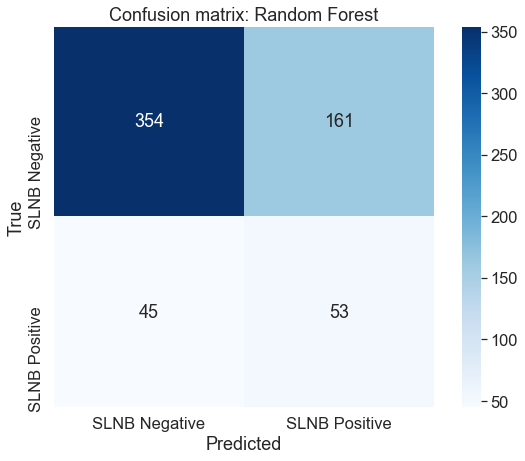

In [25]:
cm = confusion_matrix(y_test_sel, y_pred_sel)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [29]:
# pickling model
with open(BASE_DIR+'../model/balanced_rf_imputed_binned.pkl', 'wb') as f:
    pkl.dump(rf, f)

## Try different imputation

In [72]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_clean.pkl')
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE',
                        'TUMOR_SIZE', 'DEPTH', 
                        'LYMPH_VASCULAR_INVASION', 
                        'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 
                        'GROWTH_PATTERN',
                        'TUMOR_BASE_TRANSECTION',
                        'SLNB'
                       ]]


In [73]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,1,C444,1,999.0,0,999,999,999,999,0.0
14,43,1,C443,2,1.0,9,0,0,999,20,0.0
19,59,2,C447,25,50.0,0,999,999,999,999,0.0
23,82,2,C443,14,999.0,0,999,0,1,20,0.0
31,90,1,C447,15,62.0,0,999,999,999,20,0.0


In [74]:
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].value_counts()

999.0    3670
1.0      1063
20.0      923
0.0       469
Name: TUMOR_BASE_TRANSECTION, dtype: int64

In [75]:
# binning the categories
mcc_ncdb_sel['SEX'] = mcc_ncdb_sel['SEX'].replace([1, 2],
                                                ['Male', 'Female']
                                               )
mcc_ncdb_sel['PRIMARY_SITE'] = mcc_ncdb_sel['PRIMARY_SITE'].replace(['C440','C441','C442','C443',
                                                                     'C444','C445','C446','C447',
                                                                     'C448','C449'],
                                                                    ['Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Other',
                                                                     'Head_and_Neck',
                                                                     'Trunk',
                                                                     'Extremity',
                                                                     'Extremity',
                                                                     'Other',
                                                                     'Other']
                                                                   )
mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].replace([0, 1, 8, 9],
                                                                                          ['No',
                                                                                           'Yes',
                                                                                           'Unknown',
                                                                                           'Unknown'
                                                                                          ])
mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].replace(
                                                                                          [0, 1, 20, 30, 999],
                                                                                          ['Negative',
                                                                                           'Weak',
                                                                                           'Strong',
                                                                                           'Present',
                                                                                           'Unknown'
                                                                                          ])
mcc_ncdb_sel['IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].replace(
                                                                              [0, 1, 20, 30, 40,
                                                                               50, 60, 70, 999],
                                                                              ['Negative',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Unknown'
                                                                              ])
mcc_ncdb_sel['GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].replace([1, 20, 999],
                                                                          ['Circumscribed_nodular',
                                                                           'Diffusely_infiltrative',
                                                                           'Unknown'])

mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].replace([0, 1, 20, 999],
                                                                                          ['Not_found',
                                                                                           'Transected',
                                                                                           'Not_transected',
                                                                                           'Unknown'
                                                                                          ])

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [76]:
# store a copy
mcc_ncdb_sel_cp = deepcopy(mcc_ncdb_sel)

## Imputing DEPTH and TUMOR_SIZE using kNN

In [77]:
mcc_ncdb_sel['DEPTH'] = mcc_ncdb_sel['DEPTH'].replace([999],np.NaN)
mcc_ncdb_sel['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE'].replace([999],np.NaN)

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,Male,Head_and_Neck,1.0,NaN,No,Unknown,Unknown,Unknown,Unknown,0.0
14,43,Male,Other,2.0,1.0,Unknown,Negative,Negative,Unknown,Not_transected,0.0
19,59,Female,Extremity,25.0,50.0,No,Unknown,Unknown,Unknown,Unknown,0.0
23,82,Female,Other,14.0,NaN,No,Unknown,Negative,Circumscribed_nodular,Not_transected,0.0
31,90,Male,Extremity,15.0,62.0,No,Unknown,Unknown,Unknown,Not_transected,0.0


In [79]:
mcc_ncdb_sel = pd.get_dummies(mcc_ncdb_sel)
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
# impute by KNN
imputer = KNNImputer()
X_sel = imputer.fit_transform(X_sel).round()
# split data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [80]:
mcc_ncdb_sel.columns

Index(['AGE', 'TUMOR_SIZE', 'DEPTH', 'SLNB', 'SEX_Female', 'SEX_Male',
       'PRIMARY_SITE_Extremity', 'PRIMARY_SITE_Head_and_Neck',
       'PRIMARY_SITE_Other', 'PRIMARY_SITE_Trunk',
       'LYMPH_VASCULAR_INVASION_No', 'LYMPH_VASCULAR_INVASION_Unknown',
       'LYMPH_VASCULAR_INVASION_Yes',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Negative',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Present',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Strong',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Unknown',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Weak', 'IMMUNE_SUPPRESSION_Negative',
       'IMMUNE_SUPPRESSION_Positive', 'IMMUNE_SUPPRESSION_Unknown',
       'GROWTH_PATTERN_Circumscribed_nodular',
       'GROWTH_PATTERN_Diffusely_infiltrative', 'GROWTH_PATTERN_Unknown',
       'TUMOR_BASE_TRANSECTION_Not_found',
       'TUMOR_BASE_TRANSECTION_Not_transected',
       'TUMOR_BASE_TRANSECTION_Transected', 'TUMOR_BASE_TRANSECTION_Unknown'],
      dtype='object')

In [81]:
# save imputer
with open(BASE_DIR+'../model/knn_imputer.pkl', 'wb') as f:
    pkl.dump(imputer, f)

In [82]:
mcc_ncdb_sel = pd.DataFrame(np.concatenate([X_sel[:,:3],y_sel,X_sel[:,3:]], axis=1), columns=mcc_ncdb_sel.columns)
mcc_ncdb_sel_notencoded = mcc_ncdb_sel_cp
mcc_ncdb_sel_notencoded['DEPTH'] = mcc_ncdb_sel['DEPTH']
mcc_ncdb_sel_notencoded['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE']

In [87]:
# save cleaned data
mcc_ncdb_sel.to_csv(BASE_DIR+"../data/Merkel_NCDB_clean_selectedVars_encoded_imputed.csv")
mcc_ncdb_sel.to_pickle(BASE_DIR+"../data/Merkel_NCDB_clean_selectedVars_encoded_imputed.pkl")
mcc_ncdb_sel_notencoded.to_csv(BASE_DIR+"../data/Merkel_NCDB_clean_selectedVars_imputed.csv")
mcc_ncdb_sel_notencoded.to_pickle(BASE_DIR+"../data/Merkel_NCDB_clean_selectedVars_imputed.pkl")

In [88]:
X_train_sel.shape

(5512, 27)

In [89]:
mcc_ncdb_sel.columns

Index(['AGE', 'TUMOR_SIZE', 'DEPTH', 'SLNB', 'SEX_Female', 'SEX_Male',
       'PRIMARY_SITE_Extremity', 'PRIMARY_SITE_Head_and_Neck',
       'PRIMARY_SITE_Other', 'PRIMARY_SITE_Trunk',
       'LYMPH_VASCULAR_INVASION_No', 'LYMPH_VASCULAR_INVASION_Unknown',
       'LYMPH_VASCULAR_INVASION_Yes',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Negative',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Present',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Strong',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Unknown',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Weak', 'IMMUNE_SUPPRESSION_Negative',
       'IMMUNE_SUPPRESSION_Positive', 'IMMUNE_SUPPRESSION_Unknown',
       'GROWTH_PATTERN_Circumscribed_nodular',
       'GROWTH_PATTERN_Diffusely_infiltrative', 'GROWTH_PATTERN_Unknown',
       'TUMOR_BASE_TRANSECTION_Not_found',
       'TUMOR_BASE_TRANSECTION_Not_transected',
       'TUMOR_BASE_TRANSECTION_Transected', 'TUMOR_BASE_TRANSECTION_Unknown'],
      dtype='object')

In [90]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1000,
                            max_depth=50,
                            max_features = 7,
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6133768352365416
test NPV: 0.8904494382022472
test Precision: 0.22957198443579765
test Recall: 0.6020408163265306
test AUC: 0.6510501287893798
test F1: 0.3323943661971831
test AUPR: 0.28122145641633034


In [62]:
# RandomForest + Bayesian optimization
opt_rf = BayesSearchCV(BalancedRandomForestClassifier(oob_score=True,
                                     random_state=123),
                       {
                        'n_estimators': (100,2000),
                        'max_depth': (5, 100),  
                        'criterion': ['gini','entropy'],
                        'max_features': (1, 27),
                       }, 
                        n_iter = 20, verbose = 5, 
                       scoring=make_scorer(f1_score),
                       n_jobs=6)

# callback handler
def on_step(optim_result):
    score = opt_rf.best_score_
    print("best score: %s" % score)
#     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
#         pkl.dump(opt_rf, pickle_file)
    if score >= 0.5:
        print('Interrupting...')
        return True
    
opt_rf.fit(X_train_sel, y_train_sel.ravel(), callback=[on_step])

print("best parameter set: %s" % opt_rf.best_params_)
print("val. score: %s" % opt_rf.best_score_)
# print("test score: %s" % opt_rf.score(X_test, y_test))
y_prob_sel = np.asarray(opt_rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(opt_rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   18.7s remaining:   28.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   18.8s finished


best score: 0.2891887016253069
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   12.8s remaining:   19.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   13.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29535374710122986
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29535374710122986
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   13.4s remaining:   20.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   13.6s finished


best score: 0.29535374710122986
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   15.0s remaining:   22.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   15.1s finished


best score: 0.29535374710122986
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.2s remaining:    9.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.3s finished


best score: 0.29535374710122986
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   15.0s remaining:   22.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   15.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29535374710122986
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   12.4s remaining:   18.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.6s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29535374710122986
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   16.5s remaining:   24.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   16.6s finished


best score: 0.29535374710122986
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   11.8s remaining:   17.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   11.9s finished


best score: 0.29535374710122986
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   13.1s remaining:   19.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   13.2s finished


best score: 0.29535374710122986
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.2s remaining:    7.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.2s finished


best score: 0.29535374710122986
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   11.6s remaining:   17.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   11.8s finished


best score: 0.3031899708291442
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   12.1s remaining:   18.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.4s finished


best score: 0.31040830249686147
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.9s finished


best score: 0.31040830249686147
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.7s finished


best score: 0.31040830249686147
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   11.5s remaining:   17.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   11.7s finished


best score: 0.31040830249686147
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   11.5s remaining:   17.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   11.6s finished


best score: 0.31040830249686147
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.0s finished


best score: 0.31040830249686147
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    9.0s finished


best score: 0.31040830249686147
best parameter set: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 4), ('n_estimators', 1961)])
val. score: 0.31040830249686147
test accuracy: 0.6492659053833605
test NPV: 0.890625
test Precision: 0.2445414847161572
test Recall: 0.5714285714285714
test AUC: 0.6676441450366555
test F1: 0.3425076452599388
test AUPR: 0.34578764197572853


In [21]:
# def adjusted_classes(y_scores, t):
#     """
#     This function adjusts class predictions based on the prediction threshold (t).
#     Will only work for binary classification problems.
#     Credit to: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65#:~:text=The%20default%20threshold%20for%20RandomForestClassifier,the%20class%20probabilites%20called%20y_scores%20.
#     """
#     return np.asarray([1 if y >= t else 0 for y in y_scores])

# def precision_recall_threshold(p, r, thresholds, t=0.5):
#     """
#     plots the precision recall curve and shows the current value for each
#     by identifying the classifier's threshold (t).
#     """
    
#     # generate new class predictions based on the adjusted_classes
#     # function above and view the resulting confusion matrix.
#     y_pred_adj = adjusted_classes(y_scores, t)
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
#                        columns=['pred_neg', 'pred_pos'], 
#                        index=['neg', 'pos']))
    
#     # plot the curve
#     plt.figure(figsize=(8,8))
#     plt.title("Precision and Recall curve ^ = current threshold")
#     plt.step(r, p, color='b', alpha=0.2,
#              where='post')
#     plt.fill_between(r, p, step='post', alpha=0.2,
#                      color='b')
#     plt.ylim([0.5, 1.01]);
#     plt.xlim([0.5, 1.01]);
#     plt.xlabel('Recall');
#     plt.ylabel('Precision');
    
#     # plot the current threshold on the line
#     close_default_clf = np.argmin(np.abs(thresholds - t))
#     plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
#             markersize=15)

In [22]:
# decision threshold
# t = len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0])/(len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0]) + \
#                                                   len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 1]))
# t = 0.56

In [91]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1961,#1444
                            max_depth=6,#9
                            max_features = 4,#10
                            criterion = 'entropy',
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())

y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6492659053833605
test NPV: 0.890625
test Precision: 0.2445414847161572
test Recall: 0.5714285714285714
test AUC: 0.6676441450366555
test F1: 0.3425076452599388
test AUPR: 0.34578764197572853


In [92]:
# y_scores = y_prob_sel[:,1]
# p, r, thresholds = precision_recall_curve(y_test_sel, y_scores)
# precision_recall_threshold(p, r, thresholds, 0.56)

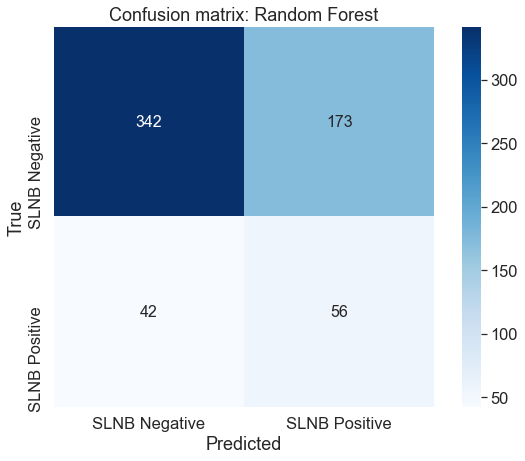

In [93]:
cm = confusion_matrix(y_test_sel, y_pred_sel)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [94]:
# pickling model
with open(BASE_DIR+'../model/balanced_rf_knnimputed_binned.pkl', 'wb') as f:
    pkl.dump(rf, f)